# Audio ML

Step by step tutorial to reproduce my results on signal processing. Be aware that each object you will create will take a lot of space in memory, you might have to restart the kernel. Don't forget to execute parent classes when using classes that have inheritance. 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
import tensorflow as tf
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
from datetime import datetime 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import librosa

import pandas as pd
import os
import glob
import struct

Using TensorFlow backend.


# PreProcessing

Extract filepath and class metadata from audio files

In [2]:
class PipelineMeta():
    
    
    def __init__(self):
        self.paths=[
    "data0db/fan/id_00",
    "data0db/fan/id_02",
    "data0db/fan/id_04",
    "data0db/fan/id_06",
    "data6db/fan/id_00",
    "data6db/fan/id_02",
    "data6db/fan/id_04",
    "data6db/fan/id_06",
    "data66db/fan/id_00",
    "data66db/fan/id_02",
    "data66db/fan/id_04",
    "data66db/fan/id_06",
]


    def datasetGenerator(self,
                        targetDir,
                        normalDirName="normal",
                        abnormalDirName="abnormal",
                        ext="wav"):

        # 01 normal list generate
        normalFiles = sorted(glob.glob(
            os.path.abspath("{dir}/{normalDirName}/*.{ext}".format(dir=targetDir,
                                                                    normalDirName=normalDirName,
                                                                    ext=ext))))
        normalLabels = False

        # 02 abnormal list generate
        abnormalFiles = sorted(glob.glob(
            os.path.abspath("{dir}/{abnormalDirName}/*.{ext}".format(dir=targetDir,
                                                                    abnormalDirName=abnormalDirName,
                                                                    ext=ext))))
        abnormalLabels = True

        normalSet = pd.DataFrame({"filePath":normalFiles,"label":normalLabels})
        abnormalSet = pd.DataFrame({"filePath":abnormalFiles,"label":abnormalLabels})
        return normalSet, abnormalSet
    
    
    def metaGenerator(self, save=False, metaFileName="Meta.csv"):
        normalSet, abnormalSet = self.datasetGenerator(self.paths[0])
        meta = normalSet.append(abnormalSet) 
        for path in self.paths[1:]:
            normalSet, abnormalSet = self.datasetGenerator(path)
            meta = meta.append(normalSet.append(abnormalSet))
        if save:
            meta.to_csv(metaFileName, index=0)
        return meta
    
        
    def __str__(self):
        return 'class to retrieve filepath and sound type metadata'

In [63]:
meta=PipelineMeta()
meta.metaGenerator(save=True)

,filePath,label
0,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,False
1,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,False
2,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,False
3,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,False
4,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,False
...,...,...
344,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,True
345,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,True
346,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,True
347,/mnt/batch/tasks/shared/LS_root/mounts/cluster...,True


Check sound file properties

In [3]:
class WavFileHelper(PipelineMeta):
    
    
    def __init__(self, metaFileName='Meta.csv'):
        try:
            self.wavMeta = pd.read_csv(metaFileName)
        except Exception as e:
            print(e, "\n", "meta.csv does not exist, generating it.")
            super().__init__()
            metaObj =  PipelineMeta()
            self.wavMeta = metaObj.metaGenerator(save=True)
    
    
    def FileProperties(self, filename):
        waveFile = open(filename,"rb")
        riff = waveFile.read(12)
        fmt = waveFile.read(36)
        numChannelsString = fmt[10:12]
        numChannels = struct.unpack('<H', numChannelsString)[0]
        sampleRateString = fmt[12:16]
        sampleRate = struct.unpack("<I",sampleRateString)[0]
        bitDepthString = fmt[22:24]
        bitDepth = struct.unpack("<H",bitDepthString)[0]
        return (numChannels, sampleRate, bitDepth)
    
    
    def readFileProperties(self):           
        audioData = []
        for index, row in self.wavMeta.iterrows():
            fileName=row['filePath']
            data = self.FileProperties(fileName)
            audioData.append(data)
        audioDf = pd.DataFrame(audioData, columns=['numChannels','sampleRate','bitDepth'])
        numChannels = audioDf.numChannels.value_counts(normalize=True)
        sampleRate = audioDf.sampleRate.value_counts(normalize=True)
        bitDepth = audioDf.bitDepth.value_counts(normalize=True)
        characteristics = {
            "number of channels":numChannels,
            "sample rate":sampleRate,
            "bit depth":bitDepth
        }
        return characteristics
    
    
    def __str__(self):
        return 'Class to extract .wav properties (sample rate, num channels, bit depth)'

In [19]:
audioProp = WavFileHelper(metaFileName="Meta.csv")
audioProp.readFileProperties()

{'number of channels': 8    1.0
 Name: numChannels, dtype: float64,
 'sample rate': 16000    1.0
 Name: sampleRate, dtype: float64,
 'bit depth': 16    1.0
 Name: bitDepth, dtype: float64}

# Feature Exctraction

Augment and extract MelPectrograms from audio files using metadata recorded in Meta.csv

In [4]:
class MelSpectrogram(PipelineMeta):
    
    
    def __init__(self, metaFileName='Meta.csv'):
        try:
            self.meta = pd.read_csv(metaFileName)
        except Exception as e:
            print(e, "\n", "meta.csv does not exist, generating it.")
            super().__init__()
            metaObj =  PipelineMeta()
            self.meta = metaObj.metaGenerator(save=True)
        self.padWidth=2
                
        
    def dataAugmentation(self, audio):
        # white noise
        wn = np.random.randn(len(audio))
        audioWn = audio + 0.005*wn
        # shifting
        audioRoll = np.roll(audio, 1600)
        # Stretching
        audioStretch = librosa.effects.time_stretch(audio, rate=1)
        
        return audioWn, audioRoll, audioStretch    

    
    def pad(self, mfccs):
        return np.pad(mfccs, pad_width=((0, 0), (0, self.padWidth)), mode='constant')
    
    
    def mfccGenerator(self, filePath, augment=True):
        audio, sampleRate = librosa.load(filePath, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sampleRate, n_mfcc=40)
        if augment:
            Wn, Roll, Stretch = self.dataAugmentation(audio)
            mfccsWn = librosa.feature.mfcc(y=Wn, sr=sampleRate, n_mfcc=40)
            mfccsRoll = librosa.feature.mfcc(y=Roll, sr=sampleRate, n_mfcc=40)
            mfccsStretch = librosa.feature.mfcc(y=Stretch, sr=sampleRate, n_mfcc=40)
            return self.pad(mfccs), self.pad(mfccsWn), self.pad(mfccsStretch), self.pad(mfccsRoll)
        else:
            return self.pad(mfccs)
        
    
    def save(self, dataFrame, fileName="totalAugmentedDf.npy"):
        temp = dataFrame.copy().to_numpy()
        np.save(fileName, temp, allow_pickle=True)


    def getMfccs(self, augment=True, save=True):
        features = []
        for i in range(len(self.meta)):
            if augment:
                valData = False
                if i%1000 == 0:
                    print(i)
                filePath = self.meta.loc[i,"filePath"]
                if filePath == "data0db/fan/id_06":
                    valData=True
                classLabel = self.meta.loc[i,"label"]
                mfccsWn, mfccsRoll, mfccsStretch, mfccs = self.mfccGenerator(filePath, augment=augment)
                augmented = False
                features.append([mfccs, classLabel, filePath, valData, augmented])
                augmented = True
                features.append([mfccsWn, classLabel, filePath, valData, augmented])
                features.append([mfccsRoll, classLabel, filePath, valData, augmented])
                features.append([mfccsStretch, classLabel, filePath, valData, augmented])
            else:
                valData = False
                if i%1000 == 0:
                    print(i)
                filePath = self.meta.loc[i,"filePath"]
                if filePath == "data0db/fan/id_06":
                    valData=True
                classLabel = self.meta.loc[i,"label"]
                mfccs = self.mfccGenerator(filePath, augment=augment)
                features.append([mfccs, classLabel, filePath, valData])
        melspecdf = pd.DataFrame(features, columns=['feature', 'classLabel', 'filePath', 'valData', 'augmented'])
        if save:
            self.save(melspecdf)
            
        return melspecdf


    def __str__(self):
        return 'Class that will load audio data, augment it if paremeter boolean "augment" is set to True, retrieve mfccs for the audio(s), pad them, label them and add meta information (augmented, validation data) as well as save under npy (numpy binary) if parameter boolean "save" is set to True'


In [65]:
melSpectrogram = MelSpectrogram()
melSpectrogram.getMfccs(augment=True, save=True)

0
1000
2000
3000
4000
5000
6000
7000


Generate multi-class label 

In [6]:
class GenerateLabel(MelSpectrogram):

    
    def __init__(self, dfFileName='totalAugmentedDf.npy'):
        """
        Initialize class to generate artificial multi class labels 
        Wrapping to total DF integrated
        
        input
        
            dfFileName: Name of binary containing previously generated MelSpectrogram DF
        """
        super().__init__()
        try:
            print('this may take a while... loading entire dataframe')
            features = np.load(dfFileName, allow_pickle=True).tolist()
            self.melSpecDf = pd.DataFrame(features, columns=['feature', 'classLabel', 'filePath', 'valData', 'augmented'])
            self.melSpecDf['featureShape'] = [x.shape for x in self.melSpecDf['feature']] 
            self.melSpecDf = self.melSpecDf[self.melSpecDf['featureShape'] == (40,433)]
            print('done! Moving on')
        except Exception as e:
            print(e, "\n", "MelSpectrograms were not saved, will generate/save/load them")
            self.melSpecDf = self.getMfccs(augment=True, save=True)
        indexAbnormal = self.melSpecDf['filePath'].str.contains('abnormal')
        indexAugmented = self.melSpecDf['augmented'] == 0
        self.abnormalMelSpecDf = self.melSpecDf.loc[(indexAbnormal) & (indexAugmented),]    
        self.normalMelSpecDf = self.melSpecDf.loc[(~indexAbnormal),]
        self.augmentedMelSpecDf = self.melSpecDf.loc[(indexAbnormal) & ~(indexAugmented),]
    
    
    def formatData(self): 
        """
        Method to flatten MelSpectrograms for PCA
        
        output
        
            flattened MelSpectrograms for all abnormal/original .wav files 
        """
        features = self.abnormalMelSpecDf.feature.tolist()
        featuresArray = np.array(features)
        nsamples, nx, ny = featuresArray.shape
        
        return featuresArray.reshape((nsamples,nx*ny))
        

    def elbowMethod(self, features):
        """
        Elbow method visualized to determine optimal nb of clusters
        
        input
        
            features: Flattened MelSpectrograms
            
        output

            graph showing intertia per nb of clusters 
        """
        ks = range(1, 10)
        inertias = []
        for k in ks:
            # Create a KMeans instance with k clusters: model
            model = KMeans(n_clusters=k)
            # Fit model to samples
            model.fit(features.iloc[:,:2])         
            # Append the inertia to the list of inertias
            inertias.append(model.inertia_)
        plt.plot(ks, inertias, '-o', color='black')
        plt.xlabel('number of clusters, k')
        plt.ylabel('inertia')
        plt.xticks(ks)
        plt.show()


    def getPCA(self, nComponents=20):
        """
        Method to apply PCA to flattened MelSpectrograms
        Automatically reshapes each array using formatData method
        Prompts user for nb of components to consider for PCA based
        on var/bias trade off for a given nb of PC
        
        input
        
            nComponents: range of PC to consider for choosing var/bias tradeoff
            
        output
        
            n principal components for MelSpectrograms
        """
        self.featuresArrayReshaped = self.formatData()
        self.X_std = StandardScaler().fit_transform(self.featuresArrayReshaped)
        pca = PCA(n_components=nComponents)
        pca.fit_transform(self.X_std)
        features = range(pca.n_components_)
        plt.bar(features, pca.explained_variance_ratio_, color='black')
        plt.xlabel('PCA features')
        plt.ylabel('variance %')
        plt.xticks(features)
        plt.show()
        try:
            self.nPC = input('From the graph displayed below, how many principal components do you want to keep?')
            assert isinstance(self.nPC, int), 'Input an integer please'
        except Exception as e:
            self.nPC = 2
        self.principalComponents = PCA(n_components=self.nPC).fit_transform(self.X_std)
        self.PCA_components = pd.DataFrame(self.principalComponents)
        plt.scatter(self.PCA_components[0], self.PCA_components[1], alpha=.1, color='black')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.show()


    def clusterViz(self, reducedData, clusterObj):
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        h = .02     
        # Plot the decision boundary. For that, we will assign a color to each
        x_min, x_max = reducedData[:, 0].min() - 1, reducedData[:, 0].max() + 1
        y_min, y_max = reducedData[:, 1].min() - 1, reducedData[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Obtain labels for each point in mesh. Use last trained model.
        Z = clusterObj.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.figure(1)
        plt.clf()
        plt.imshow(Z, interpolation='nearest',
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired,
                aspect='auto', origin='lower')

        plt.plot(reducedData[:, 0], reducedData[:, 1], 'k.', markersize=2)
        # Plot the centroids as a white X
        centroids = clusterObj.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=169, linewidths=3,
                    color='w', zorder=10)
        plt.title('K-means clustering melSpectrograms (PCA-reduced data)\n'
                'Centroids are marked with white cross')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        plt.show()
        
    
    def distToCentroid(self, labels, distances):
        self.clustersPCA = pd.DataFrame([list(i) for i in zip(labels,distances)],columns=['cluster','distance'])
        self.clustersPCA['distanceToCluster'] = self.clustersPCA['distance'].apply(lambda x: min(x))
        self.clustersPCA['distToCluster1'] = self.clustersPCA['distance'].apply(lambda x: x[0])
        self.clustersPCA['distToCluster2'] = self.clustersPCA['distance'].apply(lambda x: x[1])
        self.clustersPCA['distToCluster3'] = self.clustersPCA['distance'].apply(lambda x: x[2])
        self.clustersPCA.cluster.replace({0:1, 1:2, 2:3}, inplace=True)
        sns.displot(data=self.clustersPCA, x='distanceToCluster', hue='cluster', kde=True)
        plt.show()


    def viz3d(self):
        pca = PCA(n_components=3)
        try:
            components = pca.fit_transform(self.X_std)
        except Exception as e:
            print(e)
            self.getPCA()
        kmeans = KMeans(init='k-means++', n_clusters=self.nClt)
        kmeans.fit(components)
        kmeans.labels_
        total_var = pca.explained_variance_ratio_.sum() * 100
        fig = px.scatter_3d(
            components, x=0, y=1, z=2, color=kmeans.labels_,
            title=f'Total Explained Variance: {total_var:.2f}%',
            labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
        )
        fig.show()

        
    def cluster(self, checkNbClusters=True, visualize=True, checkDist=True, d3=False):
        self.getPCA(20)
        if checkNbClusters:
            self.elbowMethod(features=self.PCA_components)
            try:
                self.nClt = input('From the graph displayed below, how many clusters do you want?')
                assert isinstance(self.nClt, int), 'Input an integer please'
            except Exception as e:
                self.nClt = 3       
        kmeans = KMeans(init='k-means++', n_clusters=self.nClt)
        kmeans.fit(self.principalComponents)
        if visualize and self.nPC==2:
            self.clusterViz(self.principalComponents, kmeans)
        if checkDist:
            distances = kmeans.fit_transform(self.principalComponents)
            self.distToCentroid(kmeans.labels_, distances)
        if d3:
            self.viz3d()
        self.clustersPCA.reset_index(inplace=True, drop=True)
        self.abnormalMelSpecDf.reset_index(inplace=True, drop=True)
        try:
            self.abnormalMelSpecDf['cluster'] = self.clustersPCA['cluster']
        except Exception as e:
            print(e, 'need to generate temp dataframe with clusters')
            distances = kmeans.fit_transform(self.principalComponents)
            self.distToCentroid(kmeans.labels_, distances)
            self.abnormalMelSpecDf['cluster'] = self.clustersPCA['cluster']
            
    
    def getTotalDf(self, save=True):
        self.cluster()
        self.augmentedMelSpecDf.reset_index(inplace=True, drop=True)
        self.abnormalMelSpecDf.reset_index(inplace=True, drop=True)
        self.augmentedMelSpecDf = pd.merge(self.augmentedMelSpecDf,self.abnormalMelSpecDf[['filePath','cluster']], on='filePath', how='left')
        self.normalMelSpecDf['cluster'] = 0
        self.normalMelSpecDf.reset_index(inplace=True, drop=True)
        totalDf = self.normalMelSpecDf.append(self.abnormalMelSpecDf.append(self.augmentedMelSpecDf))
        if save:
            self.save(totalDf, fileName="totalAugmentedMultiClassDf.npy")
        return totalDf
    
    
    def __str__(self):
        return 'Class to apply dimensionality reduction and clustering to generate multiclass label for sound dataset'


this may take a while... loading entire dataframe
done! Moving on


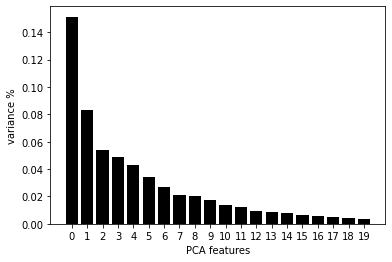

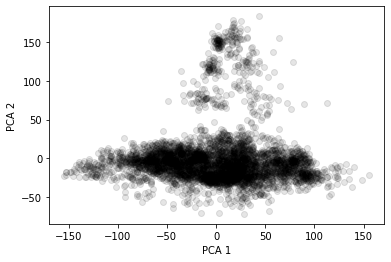

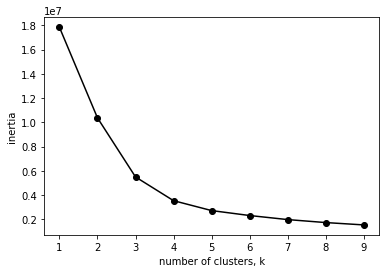

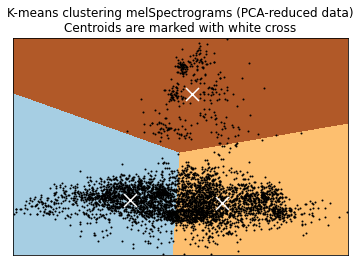

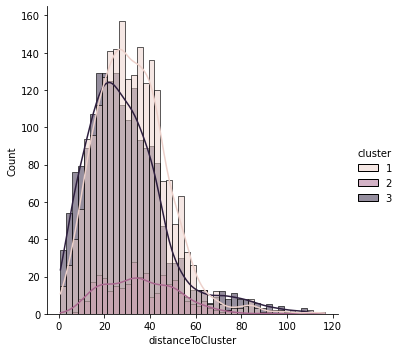

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:155: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
labelGen = GenerateLabel()
totalDf = labelGen.getTotalDf(save=False)

# Modelling

Define CNN architecture and fit model to previously generated data, recorder in totalAugmentedMutliClassDf.npy

In [7]:
class DCNN(GenerateLabel):
    
    
    def __init__(self):
        try:
            print('Trying to load total df containing multiclass labels and augmented melspectrograms')
            features = np.load('totalAugmentedMultiClassDf.npy', allow_pickle=True).tolist()
            # Convert into a Panda dataframe 
            self.totalDf = pd.DataFrame(features, columns=['feature', 'classLabel', 'filePath', 'valData', 'augmented', 'featureShape', 'cluster'])
            print('Finished feature extraction from ', len(self.totalDf), ' files') 
        except Exception as e:
            print(e, "Augmented multi labeled melspectrograms weren't generated, will create them and save as npy binary")
            super().__init__()
            labelGen = GenerateLabel()
            self.totalDf = labelGen.getTotalDf(save=True)
        indexVal = self.totalDf['valData'] == 0
        self.featuresDf = self.totalDf.copy().loc[indexVal,]
            
    
    def formatData(self):
        # Convert features and corresponding classification labels into numpy arrays
        X = np.array(self.featuresDf.feature.tolist())
        y = np.array(self.featuresDf.cluster.tolist())

        # Encode the classification labels
        le = LabelEncoder()
        self.yy = to_categorical(le.fit_transform(y)) 

        # split the dataset 
        self.xTrain, self.xTest, self.yTrain, self.yTest = train_test_split(X, self.yy, test_size=0.08, random_state = 42)
        
    
    def architecture(self, numRows=40, numColumns=433, numChannels=1, filterSize=2, lr=0.01):
        self.formatData()
        self.xTrain = self.xTrain.reshape(self.xTrain.shape[0], numRows, numColumns, numChannels)
        self.xTest = self.xTest.reshape(self.xTest.shape[0], numRows, numColumns, numChannels)
        num_labels = self.yy.shape[1]
        # Construct model 
        model = Sequential()
        model.add(Conv2D(filters=16,
                         kernel_size=2,
                         input_shape=(numRows, numColumns, numChannels),
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Conv2D(filters=32,
                        kernel_size=2, 
                        activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Conv2D(filters=64, 
                         kernel_size=2, 
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(GlobalAveragePooling2D())
        model.add(Dense(num_labels,
                        activation='softmax'))
        
        optimizer = tf.keras.optimizers.Adam(0.001)
        optimizer.learning_rate.assign(lr)
        # Compile the model
        model.compile(loss='categorical_crossentropy',
                      metrics=['accuracy'],
                      optimizer='adam')
        # Display model architecture summary 
        model.summary()
        # Calculate pre-training accuracy 
        score = model.evaluate(self.xTest, self.yTest, verbose=1)
        accuracy = 100*score[1]
        print("Pre-training accuracy: %.4f%%" % accuracy) 
        
        return model
    
    
    def fit(self, numEpochs=150, numBatchSize=256):
        model = self.architecture()
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)
        start = datetime.now()
        model.fit(self.xTrain,
                  self.yTrain, 
                  batch_size=numBatchSize, 
                  epochs=numEpochs, 
                  validation_data=(self.xTest, self.yTest), 
                  callbacks=[checkpointer],
                  verbose=1)
        duration = datetime.now() - start
        print("Training completed in time: ", duration)
        # Evaluating the model on the training and testing set
        score = model.evaluate(self.xTrain,
                               self.yTrain,
                               verbose=0)
        print("Training Accuracy: ", score[1])
        score = model.evaluate(self.xTest,
                               self.yTest,
                               verbose=0)
        print("Testing Accuracy: ", score[1])

        return model
        
        
        def __str__(self):
            return 'Class to train DCNN on MelSpectrograms, augmented, with mutli label'

In [8]:
modelTrain = DCNN()
model = modelTrain.fit()

Trying to load total df containing multiclass labels and augmented melspectrograms
Finished feature extraction from  62488  files
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 432, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 216, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 216, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 215, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 107, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 107, 32)        0